# 1.讀取資料集

透過 Kaggle 資料競賽網站，下載鐵達尼號資料集。(Link: https://www.kaggle.com/c/m5-forecasting-accuracy/data)

(點擊 "Download All" 後解壓縮，並透過下方程式碼上傳 calendar.csv, sales_train_evaluation.csv, sales_train_validation.csv, sell_prices.csv, sample_submission.csv 五份檔案)

※ 可一次上傳或分批上傳，上傳成功後，點擊左方 "Files" 欄位，即可看到上傳的檔案。 ※

In [45]:
import pandas as pd
from time import time
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Softmax
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

tic = time()

sample_submission = pd.read_csv("sample_submission.csv")
calendar = pd.read_csv("calendar.csv")
sell_prices = pd.read_csv("sell_prices.csv")
sales_train_validation = pd.read_csv("sales_train_validation.csv")
sales_train_evaluation = pd.read_csv("sales_train_evaluation.csv")

toc = time()
print(f"讀取資料一共花費 {round(toc-tic)} 秒")

讀取資料一共花費 7 秒


In [46]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [47]:
sales_train_evaluation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [48]:
sample_submission.shape

(60980, 29)

# 2.資料前處理

減少 Data 的記憶體用量
基本的特徵工程

In [49]:
sales_train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [50]:
sales_train_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [51]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [52]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [53]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [54]:
# 原本的 memory usage 是 446.4 MB
tic = time()
sales_train_validation = reduce_mem_usage(sales_train_validation)
toc = time()

print(f"This cell took {round(toc-tic)} (sec)")
sales_train_validation.info()

Mem. usage decreased to 95.00 Mb (78.7% reduction)
This cell took 104 (sec)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int16(1306), int8(607), object(6)
memory usage: 95.0+ MB


In [55]:
# 原本的 memory usage 是 208.8 MB
tic = time()
sell_prices = reduce_mem_usage(sell_prices)
toc = time()

print(f"This cell took {round(toc-tic)} (sec)")
sell_prices.info()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
This cell took 0 (sec)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int16  
 3   sell_price  float16
dtypes: float16(1), int16(1), object(2)
memory usage: 130.5+ MB


In [56]:
# 原本的 memory usage 是 215 KB
tic = time()
calendar = reduce_mem_usage(calendar)
toc = time()

print(f"\nThis cell took {round(toc-tic)} (sec)")
calendar.info()

Mem. usage decreased to  0.12 Mb (41.9% reduction)

This cell took 0 (sec)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int16 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int8  
 4   month         1969 non-null   int8  
 5   year          1969 non-null   int16 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int8  
 12  snap_TX       1969 non-null   int8  
 13  snap_WI       1969 non-null   int8  
dtypes: int16(2), int8(5), object(7)
memory usage: 125.1+ KB


將 calendar 的資訊做統整

In [57]:
# 觀察 calendar 的 column
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [58]:
# 將不會使用到的 column drop 掉
calendar = calendar.drop(["date", "weekday"], axis=1)

# 將有發生 event 的日子記下來
calendar["event"] = calendar.apply(lambda row: 1 if type(row["event_name_1"])==str else 0, axis=1)
calendar["event"] = calendar.apply(lambda row: 1 if type(row["event_name_2"])==str else 0, axis=1)

# 將不會使用到的 column drop 掉
calendar = calendar.drop(["event_name_1", "event_type_1", "event_name_2", "event_type_2"], axis=1)
calendar.head()

,wm_yr_wk,wday,month,year,d,snap_CA,snap_TX,snap_WI,event
0,11101,1,1,2011,d_1,0,0,0,0
1,11101,2,1,2011,d_2,0,0,0,0
2,11101,3,1,2011,d_3,0,0,0,0
3,11101,4,2,2011,d_4,1,1,0,0
4,11101,5,2,2011,d_5,1,0,1,0


In [59]:
calendar

,wm_yr_wk,wday,month,year,d,snap_CA,snap_TX,snap_WI,event
0,11101,1,1,2011,d_1,0,0,0,0
1,11101,2,1,2011,d_2,0,0,0,0
2,11101,3,1,2011,d_3,0,0,0,0
3,11101,4,2,2011,d_4,1,1,0,0
4,11101,5,2,2011,d_5,1,0,1,0
...,...,...,...,...,...,...,...,...,...
1964,11620,5,6,2016,d_1965,0,1,1,0
1965,11620,6,6,2016,d_1966,0,0,0,0
1966,11620,7,6,2016,d_1967,0,0,0,0
1967,11621,1,6,2016,d_1968,0,0,0,0


# 步驟三: 準備資料集

將資料整理成如同 sales_train_validation.csv 的樣式

row: 有 30490 個商品
col: 有 d_1 ~ d_1913 天的「銷量」
除了銷量以外，希望還有「售價」，i.e.,

row: 有 30490 個商品
col：有 d_1 ~ d_1913 天的「售價」
再來，每一個 day (ex: d_1, d_2, ...) 都會對應到下列資訊

event: 1 / 0
wday: 1 / 2 / 3 / 4 / 5 / 6 / 7
month: 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12
snap ...
最後輸入給 LSTM 的 tensor shape 將會是

(Batch Size, time_stamp, num_features)
(Batch Size, 28, 61009)

設計 Feature 1
銷量

In [16]:
# 因為只需要銷量，所以把其餘的 column 都 drop 掉
Feature_1 = sales_train_validation.drop(["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], axis=1)

Feature_1.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [17]:
# 使用 Transpose 是因為想要看到 time 出現在「第零維」
Feature_1 = Feature_1.to_numpy().T
Feature_1.shape

(1913, 30490)

設計 Feature 2-8
針對 dev 階段我們只需要 1913 天
Feature_2: event
Feature_3: wday
Feature_4: month
Feature_5: year
Feature_6: snap_WI
Feature_7: snap_TX
Feature_8: snap_CA

In [18]:
# Drop 掉 部分 column
Feature_2_8 = calendar[0:1913].drop(["event", "d", "wm_yr_wk", "snap_CA", "snap_TX", "snap_WI"], axis=1)

# 針對類別型態的欄位進行 one-hot encoder
Feature_2_8 = pd.get_dummies(Feature_2_8.astype(str))

# 為 Feature_2_8 這個 dataframe 新增目標 column
Feature_2_8["event"] = calendar[0:1913]["event"]
Feature_2_8["day"] = calendar[0:1913]["d"]
Feature_2_8["snap_CA"] = calendar[0:1913]["snap_CA"]
Feature_2_8["snap_TX"] = calendar[0:1913]["snap_TX"]
Feature_2_8["snap_WI"] = calendar[0:1913]["snap_WI"]
Feature_2_8 = Feature_2_8.set_index("day")
Feature_2_8.head()

,wday_1,wday_2,wday_3,wday_4,wday_5,wday_6,wday_7,month_1,month_10,month_11,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,event,snap_CA,snap_TX,snap_WI
day,,,,,,,,,,,,,,,,,,,,,
d_1,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
d_2,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
d_3,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
d_4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
d_5,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1


In [19]:
Feature_2_8 = Feature_2_8.to_numpy()

Feature_2_8.shape

(1913, 29)

設計 Feature 9
sell_price

In [20]:
# 此格用意建立 day_rule 這個 mapping 規則，
# 建立從 day 到 wm_yr_wk 的轉換關係，
# 因為我們想要有 sell_price 這個 Feature

calendar_B = pd.DataFrame()
calendar_B["wm_yr_wk"] = calendar["wm_yr_wk"]
calendar_B["d"] = calendar["d"]

day_rule = calendar_B.set_index("d").to_dict()
day_rule = day_rule["wm_yr_wk"]

day_rule

{'d_1': 11101,
 'd_2': 11101,
 'd_3': 11101,
 'd_4': 11101,
 'd_5': 11101,
 'd_6': 11101,
 'd_7': 11101,
 'd_8': 11102,
 'd_9': 11102,
 'd_10': 11102,
 'd_11': 11102,
 'd_12': 11102,
 'd_13': 11102,
 'd_14': 11102,
 'd_15': 11103,
 'd_16': 11103,
 'd_17': 11103,
 'd_18': 11103,
 'd_19': 11103,
 'd_20': 11103,
 'd_21': 11103,
 'd_22': 11104,
 'd_23': 11104,
 'd_24': 11104,
 'd_25': 11104,
 'd_26': 11104,
 'd_27': 11104,
 'd_28': 11104,
 'd_29': 11105,
 'd_30': 11105,
 'd_31': 11105,
 'd_32': 11105,
 'd_33': 11105,
 'd_34': 11105,
 'd_35': 11105,
 'd_36': 11106,
 'd_37': 11106,
 'd_38': 11106,
 'd_39': 11106,
 'd_40': 11106,
 'd_41': 11106,
 'd_42': 11106,
 'd_43': 11107,
 'd_44': 11107,
 'd_45': 11107,
 'd_46': 11107,
 'd_47': 11107,
 'd_48': 11107,
 'd_49': 11107,
 'd_50': 11108,
 'd_51': 11108,
 'd_52': 11108,
 'd_53': 11108,
 'd_54': 11108,
 'd_55': 11108,
 'd_56': 11108,
 'd_57': 11109,
 'd_58': 11109,
 'd_59': 11109,
 'd_60': 11109,
 'd_61': 11109,
 'd_62': 11109,
 'd_63': 11109,
 

In [21]:
# 使用 pandas melt 將 day_1, day_2, day_3, ..., day_1913 轉成 row 的形式
# 目的是在下一格程式碼要 使用上方建立的 day_rule 

tic = time()
sales_train_validation = pd.melt(sales_train_validation, id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], var_name="day", value_name="count")
toc = time()

print(f"Melt Dataframe 花費了 {round(toc-tic)} 秒")

Melt Dataframe 花費了 6 秒


In [22]:
sales_train_validation

,id,item_id,dept_id,cat_id,store_id,state_id,day,count
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3


In [23]:
# 利用 day_rule 我們可以知道 day 與 wm_yr_wk 的關係，
# 透過下方的 lambda 將可以在原本沒有 wm_yr_wk 的 sales_train_validation 生成 wm_yr_wk
tic = time()
sales_train_validation["wm_yr_wk"] = sales_train_validation.apply(lambda row: day_rule[row["day"]], axis=1)
toc = time()
print(f"生成欄位 wm_yr_wk 花了 {round(toc-tic)} 秒")

生成欄位 wm_yr_wk 花了 523 秒


In [24]:
sales_train_validation

,id,item_id,dept_id,cat_id,store_id,state_id,day,count,wm_yr_wk
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101
...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,11613
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,11613
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,11613
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,11613


In [25]:
# 在替 sales_train_validation 準備好 wm_yr_wk 這個 column 之後
# 於此步驟將把 sales_train_validation 和 sell_prices 合併起來
# 所以 sales_train_validation 將具備 price 的資訊
tic = time()
sales_train_validation = sales_train_validation.merge(sell_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
toc = time()
print(f"合併 sales_train_validation 和 sell_prices 花了 {round(toc-tic)} 秒")

合併 sales_train_validation 和 sell_prices 花了 13 秒


In [26]:
print((sales_train_validation["sell_price"].isnull().sum() > 0) == True)
sales_train_validation

True


,id,item_id,dept_id,cat_id,store_id,state_id,day,count,wm_yr_wk,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,NaN
...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,11613,2.980469
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,11613,2.480469
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,11613,3.980469
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,11613,1.280273


In [27]:
# 需要填補 sell_price 的缺失值，可能是因為商品初期尚未推出，故無售價
tic = time()
sales_train_validation['sell_price'] = sales_train_validation['sell_price'].fillna(sales_train_validation.groupby("id")["sell_price"].transform('mean'))
toc = time()

print(f"填補 sell_price 缺失值花了 {round(toc-tic)} 秒")

填補 sell_price 缺失值花了 7 秒


In [28]:
# 我們的目標 Feature_9: sell_price ，因此把其他的 column 給 drop 掉
Feature_9 = sales_train_validation.drop(["id", "day", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "count"], axis=1)
Feature_9

,sell_price
0,8.281250
1,3.970703
2,2.970703
3,4.523438
4,2.943359
...,...
58327365,2.980469
58327366,2.480469
58327367,3.980469
58327368,1.280273


In [29]:
print(30490 * 1913)
test_df = pd.DataFrame()
test_df["Products"] = ["Product_1", "Product_2", "Product_3", "Product_1", "Product_2", "Product_3"]
test_df.to_numpy().reshape(-1, 3)

58327370


array([['Product_1', 'Product_2', 'Product_3'],
       ['Product_1', 'Product_2', 'Product_3']], dtype=object)

In [30]:
Feature_9 = Feature_9.to_numpy().reshape(-1, 30490)
Feature_9.shape

(1913, 30490)

將三個 Feature 矩陣合而為一

In [31]:
# 將不會再使用到的 dataframe 所占用的記憶體清除
del sales_train_validation
del calendar
del calendar_B
del sell_prices

In [32]:
# 命名為 Features_Train 而非 Features，主因為後續能夠避免記憶體用量過高
Features_Train = np.concatenate([Feature_1, Feature_2_8, Feature_9], axis=1)
Features_Train.shape

(1913, 61009)

In [33]:
# 如果想要用兩個 Features 矩陣
# Features_Train = np.concatenate([Feature_1, Feature_2_8], axis=1)
# Features_Train.shape

切分資料集
若已經選定 超參數，則不需要執行此步驟

In [34]:
test_size = 0.05

split_point = int(Features_Train.shape[0] * (1-test_size))

Features_Test = Features_Train[split_point :]
Features_Train = Features_Train[: split_point]

print(f"Feature_Test  的形狀 {Features_Test.shape}")
print(f"Feature_Train 的形狀 {Features_Train.shape}")

Feature_Test  的形狀 (96, 61009)
Feature_Train 的形狀 (1817, 61009)


Feature Scaling
需要在資料是二維的情況下做

In [35]:
# 如果已經選定超參數，「不須」執行此步驟

Feature_Scaler = StandardScaler().fit(Features_Train)
Features_Test = Feature_Scaler.transform(Features_Test)
Features_Train = Feature_Scaler.transform(Features_Train)

# 再將 Dataset Concate 在一起
Features_Train = np.concatenate([Features_Test, Features_Train], axis=0)
print(Features_Train.shape)

(1913, 61009)


In [36]:
# # 假設調整完參數
# # 重新訓練
# Feature_Scaler = StandardScaler().fit(Features_Train)
# Features_Train = Feature_Scaler.transform(Features_Train)

將 Features 轉換成時間序列型態
LSTM 等循環神經網路可以使用的形式

In [37]:
# 每 ? 個 time_stamp 的資料為一組(ex: ?=28 則 day_1~day_28)，目標是預測下一個 time_stamp (ex: day_29)的所有產品銷量
time_stamps = 7

X_train = np.zeros((1913-time_stamps, time_stamps, 61009)) # Feature 1 ~ Feature 9
#X_train = np.zeros((1913-time_stamps, time_stamps, 30519)) # Feature 1 ~ Feature 8
Y_train = np.zeros((1913-time_stamps, 30490))

for index in tqdm(range(1913-time_stamps-1)):

  start = index
  end = index + time_stamps

  X_train[index] = Features_Train[start:end]
  Y_train[index] = Feature_1[end+1]

100%|██████████| 1905/1905 [00:01<00:00, 1710.76it/s]


In [38]:
# 刪去不會用到的變數，節省記憶體空間
del Feature_1
del Feature_2_8
del Feature_9

In [39]:
# 如果已經選定超參數，「不須」執行此步驟

split_point = int(X_train.shape[0] * (1-test_size))

X_test = X_train[split_point :]
Y_test = Y_train[split_point :]

X_train = X_train[: split_point]
Y_train = Y_train[: split_point]

print(f"X_train 形狀為: {X_train.shape}, Y_train 形狀為: {Y_train.shape}")
print(f"X_test 形狀為: {X_test.shape}, Y_test 形狀為: {Y_test.shape}")

X_train 形狀為: (1810, 7, 61009), Y_train 形狀為: (1810, 30490)
X_test 形狀為: (96, 7, 61009), Y_test 形狀為: (96, 30490)


# 步驟四：建立 LSTM 模型

In [40]:
drop_proba = 0.2
kernel_reg = 1e-5
recurr_reg = 1e-5
LSTM_Model = tf.keras.models.Sequential([
                                         
    LSTM(
        units = 128, 
        activation="tanh", 
        return_sequences=True, 
        dropout=drop_proba, 
        kernel_regularizer = l2(kernel_reg),
        recurrent_regularizer = l2(recurr_reg),
    ),
    
    LSTM(
        units = 512, 
        activation="tanh", 
        return_sequences=False, 
        dropout=drop_proba, 
        kernel_regularizer = l2(kernel_reg),
        recurrent_regularizer = l2(recurr_reg)
    ),

    Dense(1024, activation="relu"),
    Dropout(drop_proba),
    Dense(30490)
])

LSTM_Model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
LSTM_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            31302656  
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1312768   
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30490)             31252250  
Total params: 64,392,986
Trainable params: 64,392,986
Non-trainable params: 0
_________________________________________________________________


In [41]:
# 決定超參數
Batch_size = 64 #32
Num_of_Epoch = 50 #30
Learning_Rate = 1e-3

# 最佳化器
Optimizer_Adam = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)

# 損失函數
Loss_Function = tf.keras.losses.MeanSquaredError()

# 編譯模型
LSTM_Model.compile(
    optimizer = Optimizer_Adam,
    loss = Loss_Function, 
)

# 學習率排程器(Learning Rate Scheduler
# def scheduler(epoch, lr):
#   if epoch < 100:     
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# 訓練模型
History = LSTM_Model.fit(
  x = X_train, 
  y = Y_train, 
  batch_size=Batch_size, 
  epochs=Num_of_Epoch, 
  validation_data=(X_test, Y_test), # comment if want to use all data
  #callbacks=[callback]
)

# Ram Reach 20.53 GB

Epoch 1/50
29/29 [==============================] - 20s 685ms/step - loss: 10.8932 - val_loss: 8.0149
Epoch 2/50
29/29 [==============================] - 20s 695ms/step - loss: 7.0604 - val_loss: 6.7209
Epoch 3/50
29/29 [==============================] - 20s 693ms/step - loss: 6.4645 - val_loss: 7.6368
Epoch 4/50
29/29 [==============================] - 21s 721ms/step - loss: 6.1931 - val_loss: 6.5571
Epoch 5/50
29/29 [==============================] - 20s 697ms/step - loss: 5.9744 - val_loss: 7.3270
Epoch 6/50
29/29 [==============================] - 20s 683ms/step - loss: 5.8822 - val_loss: 8.6154
Epoch 7/50
29/29 [==============================] - 20s 686ms/step - loss: 5.7730 - val_loss: 6.5987
Epoch 8/50
29/29 [==============================] - 20s 678ms/step - loss: 5.6174 - val_loss: 8.1046
Epoch 9/50
29/29 [==============================] - 20s 702ms/step - loss: 5.4491 - val_loss: 6.9326
Epoch 10/50
29/29 [==============================] - 21s 712ms/step - loss: 5.3648 - val_l

# 5.評估模型表現

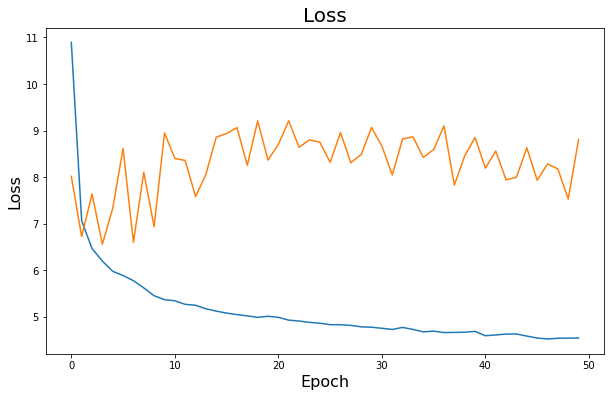

In [42]:
Train_Loss = History.history["loss"]
Val_Loss = History.history["val_loss"]

plt.figure(figsize=(10,6))
plt.plot(Train_Loss, label="Train Loss")
plt.plot(Val_Loss, label="Val Loss")
plt.title("Loss", fontsize=20)
plt.ylabel("Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.show()

# 6.觀察模型於資料集的表現

訓練資料集

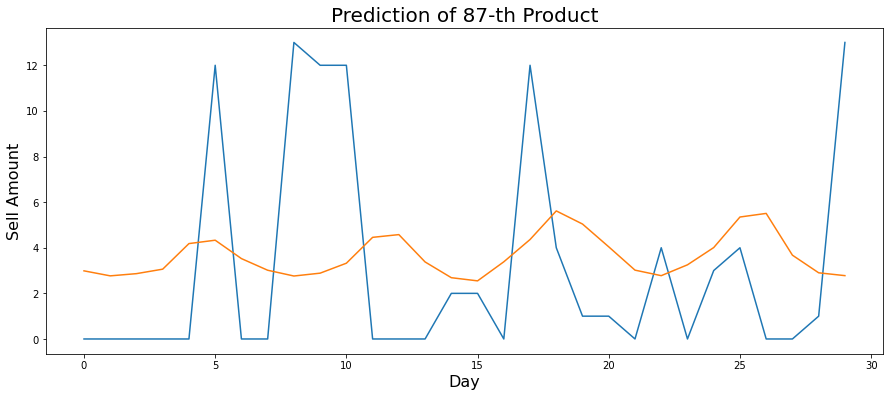

In [43]:
Start = 1780
Pred = LSTM_Model(X_train[Start:])
# Pred shape：(time, product_id)

# 挑選特定商品
product_id = 87

# 繪製
plt.figure(figsize=(15, 6))
plt.plot(Y_train[Start:, product_id])
plt.plot(Pred[:, product_id])
plt.title(f"Prediction of {product_id}-th Product", fontsize=20)
plt.xlabel("Day", fontsize=16)
plt.ylabel("Sell Amount", fontsize=16)
plt.show()

驗證資料集

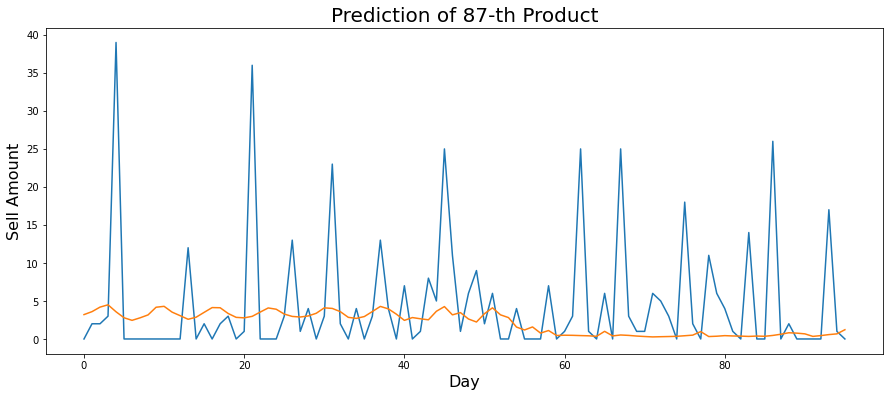

In [44]:
Pred = LSTM_Model(X_test)
# Pred shape：(time, product_id)

# 挑選特定商品
product_id = 87

# 繪製
plt.figure(figsize=(15, 6))
plt.plot(Y_test[:, product_id])
plt.plot(Pred[:, product_id])
plt.title(f"Prediction of {product_id}-th Product", fontsize=20)
plt.xlabel("Day", fontsize=16)
plt.ylabel("Sell Amount", fontsize=16)
plt.show()

# 7.(Optional)Kaggle

將步驟一到步驟二執行過一遍
因為 time_stamps 設定為 7 所以只需要保留 day_1907 後的資訊
validation 預測 day 1914 ~ 1941
evaluation 預測 day 1942 ~ 1969

Validation

In [60]:
# 想要預測 d_1914 的銷量
# 只需要 d_1907 ~ d_1913 的銷量資訊，大家知道為什麼嘛？

sales = pd.DataFrame()
sales["id"] = sales_train_validation["id"]
sales["item_id"] = sales_train_validation["item_id"]
sales["dept_id"] = sales_train_validation["dept_id"]
sales["cat_id"] = sales_train_validation["cat_id"]
sales["store_id"] = sales_train_validation["store_id"]
sales["state_id"] = sales_train_validation["state_id"]


# sales["d_1900"] = sales_train_validation["d_1900"] # 14
# sales["d_1901"] = sales_train_validation["d_1901"] # 13
# sales["d_1902"] = sales_train_validation["d_1902"] # 12
# sales["d_1903"] = sales_train_validation["d_1903"] # 11
# sales["d_1904"] = sales_train_validation["d_1904"] # 10
# sales["d_1905"] = sales_train_validation["d_1905"] # 9
# sales["d_1906"] = sales_train_validation["d_1906"] # 8
sales["d_1907"] = sales_train_validation["d_1907"] # 7
sales["d_1908"] = sales_train_validation["d_1908"] # 6
sales["d_1909"] = sales_train_validation["d_1909"] # 5
sales["d_1910"] = sales_train_validation["d_1910"] # 4 
sales["d_1911"] = sales_train_validation["d_1911"] # 3
sales["d_1912"] = sales_train_validation["d_1912"] # 2
sales["d_1913"] = sales_train_validation["d_1913"] # 1

# Feature 1 
Feature_1_val = sales.drop(["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], axis=1)
Feature_1_val = Feature_1_val.to_numpy().T

sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,1,1,2,2,2,4


In [61]:
# Drop 掉 部分 column
Feature_2_8 = calendar.drop(["event", "d", "wm_yr_wk", "snap_CA", "snap_TX", "snap_WI"], axis=1)

# 針對類別型態的欄位進行 one-hot encoder
Feature_2_8 = pd.get_dummies(Feature_2_8.astype(str))

# 為 Feature_2_8 這個 dataframe 新增目標 column
Feature_2_8["event"] = calendar["event"]
Feature_2_8["day"] = calendar["d"]
Feature_2_8["snap_CA"] = calendar["snap_CA"]
Feature_2_8["snap_TX"] = calendar["snap_TX"]
Feature_2_8["snap_WI"] = calendar["snap_WI"]
Feature_2_8 = Feature_2_8.set_index("day")

# Feature 2 - 8
Feature_2_8_target = Feature_2_8[1914-time_stamps:1941].to_numpy()

Feature_2_8.head()

,wday_1,wday_2,wday_3,wday_4,wday_5,wday_6,wday_7,month_1,month_10,month_11,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,event,snap_CA,snap_TX,snap_WI
day,,,,,,,,,,,,,,,,,,,,,
d_1,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
d_2,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
d_3,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
d_4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
d_5,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1


In [62]:
for step in tqdm(range(28)):
  
  # Feature 1
  # 已經準備好了，即是 Feature_1_val

  # Feature 2-8
  # 1st: Feature_2_8_target[0:7]
  # 2nd: Feature_2_8_target[1:8]
  # 3rd: Feature_2_8_target[2:9]
  # ...
  Feature_2_8_val = Feature_2_8_target[(time_stamps*0+step):(time_stamps*1+step)]

  # Feature 9
  # sales 將在 loop 中滾動式新增欄位
  # 完成 d_1914 的銷量預測後，會在新增 sales 新增一個欄位「d_1914」
  # 完成 d_1915 的銷量預測後，會在新增 sales 新增一個欄位「d_1915」
  # 完成 d_1916 的銷量預測後，會在新增 sales 新增一個欄位「d_1916」
  # ...
  sales_val = pd.melt(sales, id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], var_name="day", value_name="count")
  sales_val["wm_yr_wk"] = sales_val.apply(lambda row: day_rule[row["day"]], axis=1)
  sales_val = sales_val.merge(sell_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
  sales_val['sell_price'] = sales_val['sell_price'].fillna(sales_val.groupby("id")["sell_price"].transform('mean'))
  Feature_9_val = sales_val.drop(["id", "day", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "count"], axis=1)
  Feature_9_val = Feature_9_val.to_numpy().reshape(-1, 30490)
  Feature_9_val = Feature_9_val[-7:] # 每次都取最新的七天的資訊

  # 將三個 Feature 矩陣合而為一
  Features_Input = np.concatenate([Feature_1_val, Feature_2_8_val, Feature_9_val], axis=1)
  #Features_Input = np.concatenate([Feature_1_val, Feature_2_8_val], axis=1)

  # Feature Scaling
  Features_Input = Feature_Scaler.transform(Features_Input)

  # 轉換成時間序列型態
  Features_Input = Features_Input.reshape(1, time_stamps, -1) # (1,7,61009) / (1,7,30519)

  # 預測
  Features_Output = LSTM_Model(Features_Input).numpy().reshape(-1)

  # 轉換成整數 與 消除負數
  for idx in range(len(Features_Output)):
    if Features_Output[idx] < 0: Features_Output[idx] = 0
    Features_Output[idx] = round(Features_Output[idx])

  Features_Output = Features_Output.astype(np.int16).reshape(1,-1)

  # 更新 Feature_1_val，完成此步驟後，即取得下一次預測所需的 Feature 1 了
  Feature_1_val[0,:] = Feature_1_val[1,:]
  Feature_1_val[1,:] = Feature_1_val[2,:]
  Feature_1_val[2,:] = Feature_1_val[3,:]
  Feature_1_val[3,:] = Feature_1_val[4,:]
  Feature_1_val[4,:] = Feature_1_val[5,:]
  Feature_1_val[5,:] = Feature_1_val[6,:]
  Feature_1_val[6,:] = Features_Output

  # Feature_1_val[7,:] = Feature_1_val[8,:]
  # Feature_1_val[8,:] = Feature_1_val[9,:]
  # Feature_1_val[9,:] = Feature_1_val[10,:]
  # Feature_1_val[10,:] = Feature_1_val[11,:]
  # Feature_1_val[11,:] = Feature_1_val[12,:]
  # Feature_1_val[12,:] = Feature_1_val[13,:]
  # Feature_1_val[13,:] = Features_Output

  # 更新 sales，因為 Feature_3 會用到
  sales["d_"+str(1914+step)] = Features_Output.reshape(-1)

100%|██████████| 28/28 [03:03<00:00,  6.57s/it]


In [63]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1907,d_1908,d_1909,d_1910,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,1,1,3,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,4,1,0,1,...,1,1,1,1,1,1,1,1,1,1
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,1,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,0,1,...,4,4,4,4,4,4,4,4,4,4
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,0,1,0,...,2,2,2,2,2,2,2,2,2,2
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# 不 drop id

sales_top = sales.drop(["item_id", "dept_id", "cat_id", "store_id", "state_id"], axis=1)
sales_top = sales_top.drop(["d_1907", "d_1908", "d_1909", "d_1910", "d_1911", "d_1912", "d_1913"], axis=1)
#sales_top = sales_top.drop(["d_1900", "d_1901", "d_1902", "d_1903", "d_1904", "d_1905", "d_1906"], axis=1)
sales_top = sales_top.rename(columns={
    "d_1914": "F1", "d_1915": "F2", "d_1916": "F3", "d_1917": "F4", "d_1918": "F5",
    "d_1919": "F6", "d_1920": "F7", "d_1921": "F8", "d_1922": "F9", "d_1923":"F10",
    "d_1924":"F11", "d_1925":"F12", "d_1926":"F13", "d_1927":"F14", "d_1928":"F15",
    "d_1929":"F16", "d_1930":"F17", "d_1931":"F18", "d_1932":"F19", "d_1933":"F20",
    "d_1934":"F21", "d_1935":"F22", "d_1936":"F23", "d_1937":"F24", "d_1938":"F25",
    "d_1939":"F26", "d_1940":"F27", "d_1941":"F28"})

sales_top

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,HOBBIES_1_005_CA_1_validation,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,2,2,2,2,3,3,4,4,4,...,4,4,4,4,4,4,4,4,4,4
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
30487,FOODS_3_825_WI_3_validation,1,1,1,1,1,1,1,2,2,...,2,2,2,2,2,2,2,2,2,2
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
sample_submission[0:30490]

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Evaluation

In [66]:
sales = pd.DataFrame()
sales["id"] = sales_train_evaluation["id"]
sales["item_id"] = sales_train_evaluation["item_id"]
sales["dept_id"] = sales_train_evaluation["dept_id"]
sales["cat_id"] = sales_train_evaluation["cat_id"]
sales["store_id"] = sales_train_evaluation["store_id"]
sales["state_id"] = sales_train_evaluation["state_id"]

# sales["d_1928"] = sales_train_evaluation["d_1928"] # 14
# sales["d_1929"] = sales_train_evaluation["d_1929"] # 13
# sales["d_1930"] = sales_train_evaluation["d_1930"] # 12
# sales["d_1931"] = sales_train_evaluation["d_1931"] # 11
# sales["d_1932"] = sales_train_evaluation["d_1932"] # 10
# sales["d_1933"] = sales_train_evaluation["d_1933"] # 9
# sales["d_1934"] = sales_train_evaluation["d_1934"] # 8
sales["d_1935"] = sales_train_evaluation["d_1935"] # 7
sales["d_1936"] = sales_train_evaluation["d_1936"] # 6
sales["d_1937"] = sales_train_evaluation["d_1937"] # 5 
sales["d_1938"] = sales_train_evaluation["d_1938"] # 4
sales["d_1939"] = sales_train_evaluation["d_1939"] # 3
sales["d_1940"] = sales_train_evaluation["d_1940"] # 2
sales["d_1941"] = sales_train_evaluation["d_1941"] # 1

# Feature 1 
Feature_1_eval = sales.drop(["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], axis=1)
Feature_1_eval = Feature_1_eval.to_numpy().T

sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,2,1,0,0,2,1,0


In [67]:
# Drop 掉 部分 column
Feature_2_8 = calendar.drop(["event", "d", "wm_yr_wk", "snap_CA", "snap_TX", "snap_WI"], axis=1)

# 針對類別型態的欄位進行 one-hot encoder
Feature_2_8 = pd.get_dummies(Feature_2_8.astype(str))

# 為 Feature_2_8 這個 dataframe 新增目標 column
Feature_2_8["event"] = calendar["event"]
Feature_2_8["day"] = calendar["d"]
Feature_2_8["snap_CA"] = calendar["snap_CA"]
Feature_2_8["snap_TX"] = calendar["snap_TX"]
Feature_2_8["snap_WI"] = calendar["snap_WI"]
Feature_2_8 = Feature_2_8.set_index("day")

# Feature 2 - 8
Feature_2_8_target = Feature_2_8[1941-time_stamps:1969].to_numpy()

Feature_2_8.head()

,wday_1,wday_2,wday_3,wday_4,wday_5,wday_6,wday_7,month_1,month_10,month_11,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,event,snap_CA,snap_TX,snap_WI
day,,,,,,,,,,,,,,,,,,,,,
d_1,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
d_2,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
d_3,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
d_4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
d_5,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1


In [68]:
for step in tqdm(range(28)):
  
  # Feature 1
  # 已經準備好了，即是 Feature_1_val

  # Feature 2-8
  # 1st: Feature_2_8_target[0:7]
  # 2nd: Feature_2_8_target[1:8]
  # 3rd: Feature_2_8_target[2:9]
  # ...
  Feature_2_8_eval = Feature_2_8_target[(time_stamps*0+step):(time_stamps*1+step)]

  # Feature 9
  # sales 將在 loop 中滾動式新增欄位
  # 完成 d_1942 的銷量預測後，會在新增 sales 新增一個欄位「d_1942」
  # 完成 d_1943 的銷量預測後，會在新增 sales 新增一個欄位「d_1943」
  # 完成 d_1944 的銷量預測後，會在新增 sales 新增一個欄位「d_1944」
  # ...
  sales_eval = pd.melt(sales, id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], var_name="day", value_name="count")
  sales_eval["wm_yr_wk"] = sales_eval.apply(lambda row: day_rule[row["day"]], axis=1)
  sales_eval = sales_eval.merge(sell_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
  sales_eval['sell_price'] = sales_eval['sell_price'].fillna(sales_eval.groupby("id")["sell_price"].transform('mean'))
  Feature_9_eval = sales_eval.drop(["id", "day", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "count"], axis=1)
  Feature_9_eval = Feature_9_eval.to_numpy().reshape(-1, 30490)
  Feature_9_eval = Feature_9_eval[-7:] # 每次都取最新的七天的資訊

  # 將三個 Feature 矩陣合而為一
  Features_Input = np.concatenate([Feature_1_eval, Feature_2_8_eval, Feature_9_eval], axis=1)
  #Features_Input = np.concatenate([Feature_1_eval, Feature_2_8_eval], axis=1)

  # Feature Scaling
  Features_Input = Feature_Scaler.transform(Features_Input)

  # 轉換成時間序列型態
  Features_Input = Features_Input.reshape(1, time_stamps, -1) # (1,7,61009) / (1,7,30519) / (1, 14, 30519)

  # 預測
  Features_Output = LSTM_Model(Features_Input).numpy().reshape(-1)

  # 轉換成整數 與 消除負數
  for idx in range(len(Features_Output)):
    if Features_Output[idx] < 0: Features_Output[idx] = 0
    Features_Output[idx] = round(Features_Output[idx])

  Features_Output = Features_Output.astype(np.int16).reshape(1,-1)

  # 更新 Feature_1_val，完成此步驟後，即取得下一次預測所需的 Feature 1 了
  Feature_1_eval[0,:] = Feature_1_eval[1,:]
  Feature_1_eval[1,:] = Feature_1_eval[2,:]
  Feature_1_eval[2,:] = Feature_1_eval[3,:]
  Feature_1_eval[3,:] = Feature_1_eval[4,:]
  Feature_1_eval[4,:] = Feature_1_eval[5,:]
  Feature_1_eval[5,:] = Feature_1_eval[6,:]
  Feature_1_eval[6,:] = Features_Output

  # Feature_1_eval[7,:] = Feature_1_eval[8,:]
  # Feature_1_eval[8,:] = Feature_1_eval[9,:]
  # Feature_1_eval[9,:] = Feature_1_eval[10,:]
  # Feature_1_eval[10,:] = Feature_1_eval[11,:]
  # Feature_1_eval[11,:] = Feature_1_eval[12,:]
  # Feature_1_eval[12,:] = Feature_1_eval[13,:]
  # Feature_1_eval[13,:] = Features_Output
  
  # 更新 sales，因為 Feature_3 會用到
  sales["d_"+str(1942+step)] = Features_Output.reshape(-1)

100%|██████████| 28/28 [03:05<00:00,  6.63s/it]


In [69]:
# 不 drop id
sales_bot = sales.drop(["item_id", "dept_id", "cat_id", "store_id", "state_id"], axis=1)
sales_bot = sales_bot.drop(["d_1935", "d_1936", "d_1937", "d_1938", "d_1939", "d_1940", "d_1941"], axis=1)
#sales_bot = sales_bot.drop(["d_1928", "d_1929", "d_1930", "d_1931", "d_1932", "d_1933", "d_1934"], axis=1)
sales_bot = sales_bot.rename(columns={
    "d_1942": "F1", "d_1943": "F2", "d_1944": "F3", "d_1945": "F4", "d_1946": "F5",
    "d_1947": "F6", "d_1948": "F7", "d_1949": "F8", "d_1950": "F9", "d_1951":"F10",
    "d_1952":"F11", "d_1953":"F12", "d_1954":"F13", "d_1955":"F14", "d_1956":"F15",
    "d_1957":"F16", "d_1958":"F17", "d_1959":"F18", "d_1960":"F19", "d_1961":"F20",
    "d_1962":"F21", "d_1963":"F22", "d_1964":"F23", "d_1965":"F24", "d_1966":"F25",
    "d_1967":"F26", "d_1968":"F27", "d_1969":"F28"})

sales_bot

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,HOBBIES_1_005_CA_1_evaluation,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,2,2,2,2,3,3,4,4,4,...,4,4,4,4,4,4,4,4,4,4
30486,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
30487,FOODS_3_825_WI_3_evaluation,1,1,1,1,1,1,1,2,2,...,2,2,2,2,2,2,2,2,2,2
30488,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
sample_submission[30490:]

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
30490,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30491,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30492,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30493,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30494,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


合併成 sample submission 的形式

In [71]:
submission = pd.concat([sales_top, sales_bot])
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,HOBBIES_1_005_CA_1_validation,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,2,2,2,2,3,3,4,4,4,...,4,4,4,4,4,4,4,4,4,4
30486,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
30487,FOODS_3_825_WI_3_evaluation,1,1,1,1,1,1,1,2,2,...,2,2,2,2,2,2,2,2,2,2
30488,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
submission.to_csv('LSTM_V1.csv', index=False )
print( f'預測結果：' )
submission

預測結果：


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,HOBBIES_1_005_CA_1_validation,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,2,2,2,2,3,3,4,4,4,...,4,4,4,4,4,4,4,4,4,4
30486,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
30487,FOODS_3_825_WI_3_evaluation,1,1,1,1,1,1,1,2,2,...,2,2,2,2,2,2,2,2,2,2
30488,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
